In [5]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, Predictive

from jax import random
import jax
import jax.numpy as jnp

import arviz as az
import matplotlib.pyplot as plt

In [10]:
import skbio 
import numpy as np
from helper import custom_put_along_axis

## Preprocessing 

In [80]:
def seq_mapping(seq, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    mapped = []
    for base in seq:
            mapped.append(alphabet.find(base))
    return jnp.array(mapped)

def fasta2ref(fref_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    for seq in skbio.io.read(fref_in, format='fasta'):
        ref = seq_mapping(str(seq), alphabet)
    #print('reference ', str(seq))
    return ref

def fasta2reads(freads_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    reads_mapped = []
    read_id = []
    # print('reads')
    for seq in skbio.io.read(freads_in, format="fasta"):
        # print(str(seq))
        read_id.append(seq.metadata['id'])
        reads_mapped.append(seq_mapping(str(seq), alphabet))
    return jnp.array(reads_mapped), read_id

## Input

In [98]:
# Minimal example input

reference = jnp.array([0])
reads = jnp.array([[[0], [1], [1], [1]], 
                   [[0], [1], [1], [1]]])
alphabet ='01'

cluster_num = 5

input_data = reference, reads, len(alphabet), cluster_num

In [277]:
# Bigger example input 

fref_in='../../../test_data/super_small_multiple_samples/ref.fasta'
list_freads_in=['../../../test_data/super_small_multiple_samples/seqs0.fasta', 
           '../../../test_data/super_small_multiple_samples/seqs1.fasta',
           '../../../test_data/super_small_multiple_samples/seqs2.fasta']

list_sample_ids=['seqs0','seqs1','seqs2']

alphabet ='ACGT-'
alphabet_length = len(alphabet) # size alphabet

# Coding scheme
# 0:A, 1:C, 2:G, 3:T 4:-, 5:N

reference = fasta2ref(fref_in, alphabet)
reads_ids = [fasta2reads(freads_in, alphabet)[1] for freads_in in list_freads_in]
reads = [fasta2reads(freads_in, alphabet)[0] for freads_in in list_freads_in]
reads = jnp.array(reads)

cluster_num = 5

input_data = reference, reads, len(alphabet), cluster_num

In [278]:
print(reads.shape) # n_samples, n_read, genome_length

(3, 7, 9)


In [279]:
reads_ids

[['seq1', 'ref', 'ref', 'ref', 'seq3', 'seq3', 'seq3'],
 ['seq1', 'ref', 'ref', 'ref', 'seq3', 'seq3', 'seq3'],
 ['seq1', 'seq1', 'seq1', 'ref', 'seq3', 'seq3', 'seq3']]

In [280]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    pad_beta = jnp.pad(beta, ((0, 0),(0, 1)), constant_values=1)
    pad_beta1m_cumprod = jnp.pad(beta1m_cumprod, ((0, 0),(1, 0)), constant_values=1)
    
    return pad_beta*pad_beta1m_cumprod

def shape_parameters(alpha, beta):
    # first shape parameter of beta distribution 
    first = alpha * beta
    
    # second shape parameter of beta distribution 
    beta_cumsum = beta.cumsum(-1) # K-1 dimensional 
    second = jnp.pad(beta_cumsum, (1, 0), constant_values=0)
    second = second[:-1]
    second = alpha * (1 - second)
    
    return [first, second]


def model_hierarchicalSBMM(input_data):
    reference, read_data, alphabet_length, max_cluster_num_guess = input_data

    # parameters
    samples_count = read_data.shape[0]
    read_count = read_data.shape[1]
    genome_length = reference.shape[0]
    alphabet_length = alphabet_length 
    
    # set hyperparameters
    gamma = 1.1
    alpha = 1.1
    
    # define rates
    mutation_rate = numpyro.sample("mutation_rate", dist.Beta(1, 1))
    error_rate = numpyro.sample("error_rate", dist.Beta(1, 1))

    # create matrix of rates
    mutation_rate_matrix = jnp.full(
        (genome_length, alphabet_length), (1 - mutation_rate) / (alphabet_length - 1)
    )
    mutation_rate_matrix = custom_put_along_axis(
        mutation_rate_matrix, reference.reshape(genome_length, 1), mutation_rate, axis=1
    )
    
    # top hierarchical level - base distribution for all samples
    beta_plate = numpyro.plate("beta_plate", max_cluster_num_guess - 1)
    with beta_plate:
        beta_top = numpyro.sample("beta_top", dist.Beta(1*jnp.ones(max_cluster_num_guess - 1), gamma*jnp.ones(max_cluster_num_guess - 1)))

    # sample level - draw weights for each sample
    sample_plate = numpyro.plate("sample_plate", samples_count, dim=-2)
    with sample_plate:
        param = shape_parameters(alpha, beta_top)
        beta = numpyro.sample("beta", dist.Beta(param[0],param[1]))
    
    cluster_weights = numpyro.sample(
    "cluster_weights", dist.Dirichlet(mix_weights(beta))
    ) # n_samples X num_cluster
        
    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", max_cluster_num_guess, dim=-2):
        with genome_axis:
            haplotypes = numpyro.sample(
                "haplotypes", dist.Categorical(mutation_rate_matrix)
            )  # cluster centers

    with numpyro.plate("sample_plate", samples_count, dim=-2):
        with numpyro.plate("read_axis", read_count, dim=-1):
            cluster_weights = jnp.repeat(cluster_weights[:,jnp.newaxis,:], read_count, axis=1)
    cluster_assignments = numpyro.sample(
        "cluster_assignments", dist.Categorical(cluster_weights)
    ) # n_samples x n_reads 

    with numpyro.plate("sample_plate", samples_count, dim=-3):    
        with numpyro.plate("read_axis", read_count, dim=-2):
            with genome_axis:
                error_rate_matrix = jnp.full(
                    (samples_count, read_count, genome_length, alphabet_length),
                    (1 - error_rate) / (alphabet_length - 1),
                )
                error_rate_matrix = custom_put_along_axis(
                    error_rate_matrix,
                    haplotypes[cluster_assignments].reshape(samples_count, read_count, genome_length, 1),
                    error_rate,
                    axis=3,
                )

                numpyro.sample("obs", dist.Categorical(error_rate_matrix), obs=read_data)

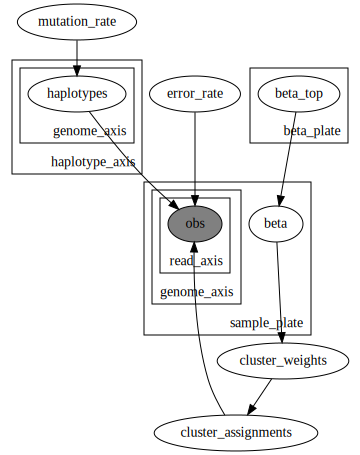

In [281]:
numpyro.render_model(model_hierarchicalSBMM, model_args=(input_data,))

## Model inference with MCMC (HMC + Gibbs)   
#### - Use of HMC for continuous and Gibbs sampling for discrete variables.

In [282]:
rng_key = jax.random.PRNGKey(0)
num_samples = 500
num_warmup = int(num_samples / 2)

model = model_hierarchicalSBMM

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(
    DiscreteHMCGibbs(kernel),
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=1
)
mcmc.run(rng_key, input_data)

sample: 100%|███████████████████████████████████████████████████| 750/750 [00:52<00:00, 14.22it/s, 1023 steps of size 3.03e-08. acc. prob=0.73]


In [283]:
mcmc.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
               beta[0,0]      0.56      0.00      0.56      0.56      0.56      0.50      1.00
               beta[0,1]      0.58      0.00      0.58      0.58      0.58      0.50      1.00
               beta[0,2]      0.59      0.00      0.59      0.59      0.59      0.50      1.00
               beta[0,3]      0.87      0.00      0.87      0.87      0.87      0.50      1.00
               beta[1,0]      0.90      0.00      0.90      0.90      0.90      0.50      1.00
               beta[1,1]      0.63      0.00      0.63      0.63      0.63      0.50      1.00
               beta[1,2]      0.85      0.00      0.85      0.85      0.85      0.50      1.00
               beta[1,3]      0.24      0.00      0.24      0.24      0.24      0.50      1.00
               beta[2,0]      0.20      0.00      0.20      0.20      0.20      0.50      1.00
               beta[2,1]      0.53      0.00     

In [284]:
posterior_samples = mcmc.get_samples()

In [252]:
posterior_samples

{'beta': DeviceArray([[[0.15048507, 0.1492501 , 0.78917956, ..., 0.66552883,
                0.77285314, 0.87546   ],
               [0.8468671 , 0.7758716 , 0.86752367, ..., 0.12907606,
                0.48507273, 0.6281886 ],
               [0.8168245 , 0.7837722 , 0.16383778, ..., 0.7511588 ,
                0.48109415, 0.5943088 ]],
 
              [[0.15048507, 0.1492501 , 0.78917956, ..., 0.66552883,
                0.77285314, 0.87546   ],
               [0.8468671 , 0.7758716 , 0.86752367, ..., 0.12907606,
                0.48507273, 0.6281886 ],
               [0.8168245 , 0.7837722 , 0.16383778, ..., 0.7511588 ,
                0.48109415, 0.5943088 ]],
 
              [[0.15048507, 0.1492501 , 0.78917956, ..., 0.66552883,
                0.77285314, 0.87546   ],
               [0.8468671 , 0.7758716 , 0.86752367, ..., 0.12907606,
                0.48507273, 0.6281886 ],
               [0.8168245 , 0.7837722 , 0.16383778, ..., 0.7511588 ,
                0.48109415, 0.5943088

In [253]:
# Make sure to infer_discrete
# Predictive obtained by running model conditioned on latent samples from posterior_samples p(theta | data)

posterior_predictive = Predictive(model, posterior_samples, infer_discrete=True)
posterior_predictions = posterior_predictive(rng_key, input_data=input_data)

KeyError: 'genome_axis'

In [ ]:
# computes expected log predictive density at each data point

from numpyro.infer.util import log_likelihood

log_likelihood = log_likelihood(model, posterior_samples, input_data=input_data )
#log_likelihood['obs']

In [ ]:
inference_data = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=posterior_predictions,
)
display(inference_data)

In [ ]:
az.plot_forest(inference_data, combined=True)

In [ ]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True)
plt.show()

## Postprocessing

In [16]:
import scipy

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

In [191]:
def convert_h_to_seq(h, alphabet):
    '''
    Convert numeric representation to DNA-seq representation.
    '''
    seq = [alphabet[int(h[k])] for k in range(h.shape[0])]
    return ''.join(seq)

In [94]:
posterior_predictive = Predictive(model, posterior_samples, infer_discrete=True)

In [95]:
posterior_predictive(rng_key, input_data=input_data)

KeyError: 'genome_axis'

In [254]:
def corrected_reads_to_fasta(posterior_samples, model, input_data, rng_key, list_read_ids, list_sample_ids,fname_output_corr, alphabet,last_x_samples=100):

    # TODO: Do we want to cut posterior samples?
    reads = input_data[1]

    # only consider the last {last_x_samples} samples to summarize results
    cluster_assignments = posterior_samples['cluster_assignments'][-last_x_samples:,:,:]
    haplotypes = posterior_samples['haplotypes'][-last_x_samples:,:,:]

    average_cluster_assignment = scipy.stats.mode(cluster_assignments, axis=0)[0][0] # n_samples x n_reads
    average_haplotypes = scipy.stats.mode(haplotypes, axis=0)[0][0]

    # computes empirical posterior from posterior_samples p(theta | data)
    #posterior_predictive = Predictive(model, posterior_samples, infer_discrete=True)
    #print(posterior_predictive(rng_key, input_data=input_data)['obs'].shape)
    #posterior_predictions = posterior_predictive(rng_key, input_data=input_data)['obs'][-last_x_samples:,:,:]
    #posterior = [(posterior_predictions[:,n,:]==reads[n][:]).all(-1).sum() / last_x_samples for n in range(len(list_read_ids))]
    
    for m , read_in_sample in enumerate(list_read_ids):
        records = []
        for n ,read_id in enumerate(read_in_sample):
            hap_seq = convert_h_to_seq(average_haplotypes[average_cluster_assignment[m][n]], alphabet)
            #header = '|posterior=' + str(posterior[n])
            header = '|posterior=' + str(1)
            records.append(SeqRecord(Seq(hap_seq), id=read_id, description=header))

        SeqIO.write(records, fname_output_corr+list_sample_ids[m]+'-corr.fasta', "fasta")

In [255]:
def haplotypes_to_fasta(posterior_samples, model, input_data, rng_key, fname_output_corr, alphabet, last_x_samples=100):
    genome_length = posterior_samples['haplotypes'].shape[2]
    alphabet_length = len(alphabet)

    # only consider the last {last_x_samples} samples to summarize results
    cluster_assignments = posterior_samples['cluster_assignments'][-last_x_samples:,:,:]
    haplotypes = posterior_samples['haplotypes'][-last_x_samples:,:,:]

    # number of reads assigned to each haplo
    hap_ids, ave_reads = np.unique(cluster_assignments, return_counts=True)

    # collapse haplotypes into unique set
    average_haplotypes = scipy.stats.mode(haplotypes, axis=0)[0][0]
    unique_haplotypes = np.unique(average_haplotypes, axis=0)
    idx_collapsed_haplotypes = [np.where(np.all(average_haplotypes==unique_hap,axis=1)) for unique_hap in unique_haplotypes]
    idx_collapsed_haplotypes = [np.intersect1d(idx_col,hap_ids) for idx_col in idx_collapsed_haplotypes]
    # map idx_collapsed_haplotypes to hap_ids order
    outer = []
    for idx_collapsed in idx_collapsed_haplotypes:
        outer.append([np.argwhere(hap_ids==i)[0][0] for i in idx_collapsed])
    mapped_idx_collapsed_haplotypes = outer

    # collapse number of average reads to unique haplotypes
    ave_reads = np.array([np.sum(ave_reads[idx_hap]) for idx_hap in mapped_idx_collapsed_haplotypes])
    ave_reads = ave_reads / last_x_samples

    # empirical posteriors of haplotypes (collapsed like in ave_reads computation)
    posterior_predictive = Predictive(model, 
                                      posterior_samples, 
                                      infer_discrete=True, 
                                      return_sites=['haplotypes']
                                     )
    posterior_predictions = posterior_predictive(rng_key, 
                                                 input_data=input_data
                                                )['haplotypes'][-last_x_samples:,:,:]
    posterior = [(posterior_predictions[:,hap_ids[idx_hap],:]==average_haplotypes[hap_ids[idx_hap]][:]).all(-1).sum() / last_x_samples for idx_hap in mapped_idx_collapsed_haplotypes]

    # write to fasta
    records = []
    for k in range(unique_haplotypes.shape[0]):
        head = ' | posterior='+str(posterior[k])+' ave_reads='+str(ave_reads[k])
        seq = convert_h_to_seq(unique_haplotypes[k], alphabet)
        records.append(SeqRecord(Seq(seq), id='haplotype'+str(k), description=head))
    SeqIO.write(records, fname_output_corr, "fasta")


------

In [256]:
haplotypes_to_fasta(posterior_samples,
                    model, 
                    input_data, 
                    rng_key, 
                    '/Users/lfuhrmann/Downloads/haplos.fasta', 
                    alphabet, 
                    last_x_samples=100)

KeyError: 'genome_axis'

In [257]:
corrected_reads_to_fasta(posterior_samples, 
                         model, 
                         input_data, 
                         rng_key, 
                         reads_ids, 
                         list_sample_ids,
                         '/Users/lfuhrmann/Downloads/',
                         alphabet,
                         last_x_samples=100)
    

In [258]:
scipy.stats.mode(posterior_samples['haplotypes'], axis=0)[0][0]

array([[2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0],
       [2, 3, 3, 2, 0, 2, 3, 0, 0]], dtype=int32)

## Check the results very roughly

In [272]:
# input data reads
input_data[1]

DeviceArray([[[2, 3, 0, 0, 0, 2, 3, 0, 0],
              [2, 3, 3, 2, 0, 2, 3, 0, 0],
              [2, 3, 3, 2, 0, 2, 3, 0, 0],
              [2, 3, 3, 2, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0]],

             [[2, 3, 0, 0, 0, 2, 3, 0, 0],
              [2, 3, 3, 2, 0, 2, 3, 0, 0],
              [2, 3, 3, 2, 0, 2, 3, 0, 0],
              [2, 3, 3, 2, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0]],

             [[2, 3, 0, 0, 0, 2, 3, 0, 0],
              [2, 3, 0, 0, 0, 2, 3, 0, 0],
              [2, 3, 0, 0, 0, 2, 3, 0, 0],
              [2, 3, 3, 2, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0],
              [2, 3, 3, 3, 0, 2, 3, 0, 0]]], dtype=int32)

In [273]:
posterior_samples['haplotypes'].shape

(1000, 20, 9)

In [274]:
scipy.stats.mode(posterior_samples['haplotypes'][-100:,:,:], axis=0)

ModeResult(mode=array([[[2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0],
        [2, 3, 3, 2, 0, 2, 3, 0, 0]]], dtype=int32), count=array([[[ 94,  90,  90,  80,  94,  96,  93,  94,  89],
        [ 92,  92,  82,  82,  93,  93,  93,  94,  96],
        [ 96,  96,  96,  81,  96,  99,  99,  94,  98],
        [ 95,  94,  96,  83,  98,  92,  96,  97,  96],
  

In [275]:
posterior_samples['cluster_assignments'].shape 
# n_drawn_samples x n_data_samples x n_reads

(1000, 3, 7)

In [276]:
scipy.stats.mode(posterior_samples['cluster_assignments'][-100:,:,:], axis=0)

ModeResult(mode=array([[[2, 8, 3, 2, 2, 2, 2],
        [7, 8, 8, 3, 3, 7, 3],
        [0, 5, 0, 5, 5, 5, 0]]], dtype=int32), count=array([[[16, 21, 21, 19, 22, 28, 20],
        [25, 22, 22, 22, 21, 30, 24],
        [20, 24, 20, 21, 25, 27, 22]]]))

In [ ]:
# inferred haplotypes
scipy.stats.mode(posterior_samples['haplotypes'][-50:,:,:], axis=0)[0][0]

In [ ]:
scipy.stats.mode(posterior_samples['cluster_assignments'][-4:,:,:], axis=0)[0][0]

In [ ]:
scipy.stats.mode(posterior_samples['cluster_assignments'][-100:,:,:], axis=0)[0][0]

In [ ]:
# inferred cluster assignments
scipy.stats.mode(posterior_samples['cluster_assignments'], axis=0)[0][0]

In [ ]:
# inferred no-mutation rate
np.mean(posterior_samples['mutation_rate'])

In [ ]:
# inferred no-error rate
np.mean(posterior_samples['error_rate'])